In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
sys.path.append('../src')
# from utils import load_weather
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [2]:
F_INPUT = '../../data/data.merged.pandas.h5'

In [3]:
df = pd.read_hdf(F_INPUT, 'resampled/median')

In [4]:
df['month'] = df['datenum'].index.month

In [5]:
df_subset = df[(df.index >= '2018-10-01') & (df.index < '2019-01-01')]

In [6]:
df_subset.describe()

,pressure,relative_humidity,temperature,wind_direction,wind_speed,datenum,o(I)_I,r0,solar_zenith_angle,Cn2,month
count,128294.000000,128294.000000,128294.000000,132309.000000,132309.000000,51822.000000,25670.000000,51822.000000,51822.000000,1.160820e+05,132480.000000
mean,774.035263,40.750269,6.626315,166.847920,2.219250,737376.459411,0.001444,5.982451,96.471342,1.460209e-15,11.000000
std,4.081847,28.705258,5.102259,76.334054,1.521876,26.297726,0.000458,3.174025,40.110685,1.944157e-15,0.820925
min,758.400000,2.000000,-10.300000,3.578947,0.100000,737334.099005,0.000341,0.986535,37.768087,1.180600e-18,10.000000
25%,772.000000,19.000000,3.500000,91.900000,1.145000,737353.501311,0.001102,3.444640,58.793091,2.865725e-16,10.000000
50%,774.500000,32.000000,6.800000,180.400000,1.820000,737374.316944,0.001429,5.429000,95.804247,8.191250e-16,11.000000
75%,776.800000,57.000000,9.800000,226.950000,2.870000,737396.699463,0.001735,7.832000,134.399380,1.807000e-15,12.000000
max,783.800000,103.000000,22.800000,357.650000,12.515789,737425.961285,0.003461,25.415223,169.053912,1.995200e-14,12.000000


In [7]:
feats = ['pressure', 'relative_humidity', 'temperature', 'wind_speed', 'month', 'Cn2', 'solar_zenith_angle']
label = 'r0'

In [8]:
valid = ~df_subset.isnull().any(axis=1)

In [9]:
df_subset[valid].count()

pressure              24233
relative_humidity     24233
temperature           24233
wind_direction        24233
wind_speed            24233
datenum               24233
o(I)_I                24233
r0                    24233
solar_zenith_angle    24233
Cn2                   24233
month                 24233
dtype: int64

In [10]:
train = df_subset.index <= '2018-12-10'
test  = df_subset.index > '2018-12-10'

In [11]:
df_subset.loc[train & valid,feats].count()

pressure              20119
relative_humidity     20119
temperature           20119
wind_speed            20119
month                 20119
Cn2                   20119
solar_zenith_angle    20119
dtype: int64

In [12]:
df_subset.loc[test & valid,feats].count()

pressure              4114
relative_humidity     4114
temperature           4114
wind_speed            4114
month                 4114
Cn2                   4114
solar_zenith_angle    4114
dtype: int64

In [13]:
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(df_subset.loc[train&valid,feats], df_subset.loc[train&valid,label])

RandomForestRegressor(random_state=0)

In [14]:
preds = regr.predict(df_subset.loc[test&valid,feats])
r2 = regr.score(df_subset.loc[test&valid,feats], df_subset.loc[test&valid,label])

In [15]:
r2

0.4022089757079189

In [16]:
def error_diff(targ, pred):
    return targ-pred

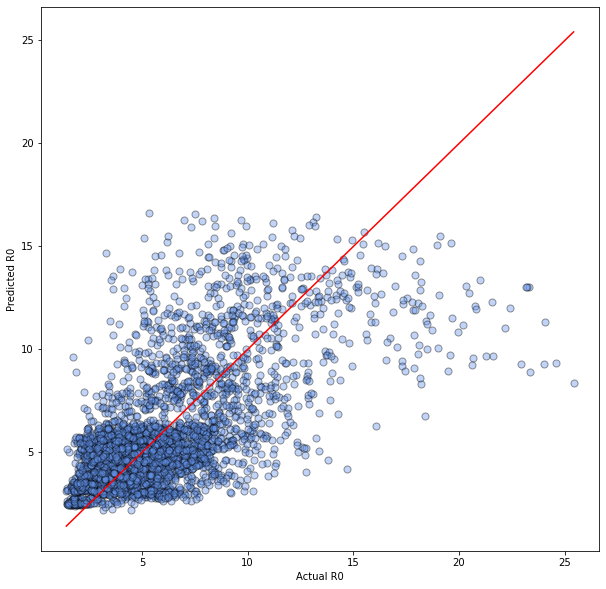

In [17]:
plt.figure(figsize=(10,10))
s = 50
a = 0.4
plt.scatter(df_subset.loc[test&valid,label],
           preds,
           edgecolor='k', c="cornflowerblue", s=s, alpha=a)
x = np.linspace(df_subset.loc[test&valid,label].min(), df_subset.loc[test&valid,label].max(), 1000)
plt.plot(x, x, 'r-')
plt.xlabel("Actual R0")
plt.ylabel("Predicted R0")
plt.show()
